# Gradient Boosting Machines for Wine Points Predictions

Wine Spectator's 100-Point Scale

95-100 Classic: a great wine.

90-94 Outstanding: a wine of superior character and style.

85-89 Very good: a wine with special qualities.

80-84 Good: a solid, well-made wine.

75-79 Mediocre: a drinkable wine that may have minor flaws.

50-74 Not recommended.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import RegexpTokenizer
import xgboost as xgb

In [3]:
#Load data
wine = pd.read_csv('data/winemag-data_first150k.csv', index_col=0, encoding="utf-8")
wine.dropna(subset=["price", "points"], inplace=True)
wine.reset_index(inplace=True, drop=True)
wine = wine[['description', 'price', 'points']]
print(wine.shape)
wine.sample(3)

(137235, 3)


,description,price,points
10145,From a vineyard just behind the beach at Pampe...,18.0,88
64099,"A smooth wine that softens well, but that stil...",20.0,90
128000,"Chunky and spicy on the nose, with mid-level p...",10.0,84


# Feature Engineering

In [4]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

wine["description"] = wine["description"].str.replace('\d+', '')
wine["description"] = wine.description.apply(func=remove_punctuation)
wine["description"] = wine.description.apply(func=make_lower_case)

<ipython-input-4-848bbd22fd97>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  wine["description"] = wine["description"].str.replace('\d+', '')


In [5]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=5)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(wine.description)
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["latent_description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

,latent_description_0,latent_description_1,latent_description_2,latent_description_3,latent_description_4
0,0.122660,-0.036942,-0.006609,-0.023325,-0.027913
1,0.135296,-0.041562,0.014860,-0.013014,0.008989
2,0.077102,0.047122,-0.015789,-0.006761,0.010789
3,0.147137,-0.097132,0.032039,-0.001155,0.027754
4,0.083745,0.001510,-0.080835,-0.099804,-0.022647


# XGBoost Classification

In [20]:
#Make atest train split
X = pd.concat([lsa_features, wine["price"]], axis=1)
y = wine["points"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Format data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 10

#Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[10:10:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mae:2.06017
[1]	train-mae:1.96985
[2]	train-mae:1.93942
[3]	train-mae:1.92326
[4]	train-mae:1.89162
[5]	train-mae:1.87178
[6]	train-mae:1.86415
[7]	train-mae:1.85775
[8]	train-mae:1.84255
[9]	train-mae:1.83710


/Users/clairelongo/PycharmProjects/wine_quality_predictions/venv/lib/python3.8/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


In [7]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

mean_ae = np.round(mean_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
median_ae = np.round(median_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
print ("Mean Absolute Error: {} points".format(mean_ae))

Mean Absolute Error: 1.85 points


/Users/clairelongo/PycharmProjects/wine_quality_predictions/venv/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

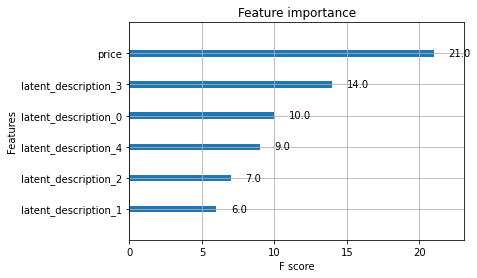

In [8]:
xgb.plot_importance(bst,max_num_features=15)

In [58]:
#Save your models
import joblib
import os

model_dir = "model/"

 ## save TF-IDF and SVD models
joblib.dump(tf, os.path.join(model_dir, "tfidf.joblib"))
print("TFIDF processor trained and saved!".format(os.path.join(model_dir, "tfidf.joblib")))

joblib.dump(svd, os.path.join(model_dir, "svd.joblib"))
print("SVD processor trained and saved!".format(os.path.join(model_dir, "svd.joblib")))

#Save xgboost model
joblib.dump(bst, os.path.join(model_dir, "model.joblib"))
print("XGboost Model trained and saved!".format(os.path.join(model_dir, "model.joblib")))

TFIDF processor trained and saved!
SVD processor trained and saved!
XGboost Model trained and saved!


In [59]:
#xgb.to_graphviz(bst, num_trees=1)

# Integrate with Arize

In [60]:
#Lets f around with Arize. Lets use the pandas logger to get some
#and use the real time logger to get some inference in for some live examples.

In [9]:
#WTF Does our data look like?

df_test = X_test.copy()
df_test["ACTUALS"] = y_test #add the labels
df_test["ACTUALS"] = df_test["ACTUALS"].astype('float64')
df_test["PREDICTED"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit) #add the actuals
df_test["PREDICTED"] = df_test["PREDICTED"].astype('float64')
df_test.reset_index(inplace=True)
df_test["ITEM_ID"] = df_test[['index', 'latent_description_0', 'price']].sum(axis=1).map(hash)
df_test.drop(columns=['index'], inplace=True)

#Make a tag to call it test data
df_test["test_data"] = 1
#make a made-up tag for red and white wines
df_test["type"] = "White"
df_test.iloc[0:20000, df_test.columns.get_loc('type')] = "Red"
df_test.head()

/Users/clairelongo/PycharmProjects/wine_quality_predictions/venv/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,latent_description_0,latent_description_1,latent_description_2,latent_description_3,latent_description_4,price,ACTUALS,PREDICTED,ITEM_ID,test_data,type
0,0.062276,-0.024134,0.034599,0.005343,0.005947,75.0,95.0,88.680779,143597770043857246,1,Red
1,0.119464,-0.011537,0.034213,-0.036058,0.067551,30.0,90.0,89.040749,275465994066019657,1,Red
2,0.157964,-0.100228,-0.035699,0.083655,-0.008681,20.0,84.0,85.803169,364239323660383763,1,Red
3,0.106518,-0.006388,0.034230,0.017197,-0.035522,39.0,91.0,88.337486,245614778599459688,1,Red
4,0.088124,-0.053319,0.001254,-0.039704,-0.000437,53.0,89.0,91.169510,203200149344781774,1,Red


In [10]:
df_test.dtypes

latent_description_0    float64
latent_description_1    float64
latent_description_2    float64
latent_description_3    float64
latent_description_4    float64
price                   float64
ACTUALS                 float64
PREDICTED               float64
ITEM_ID                   int64
test_data                 int64
type                     object
dtype: object

In [12]:
feature_column_names = ['latent_description_0',
                        'latent_description_1',
                        'latent_description_2',
                        'latent_description_3',
                        'latent_description_4',
                        'price']

test_schema = Schema(
    prediction_id_column_name="ITEM_ID",
    prediction_label_column_name="PREDICTED",
    actual_label_column_name="ACTUALS",
    feature_column_names=feature_column_names,
    tag_column_names =['test_data','type'],
)

NameError: name 'Schema' is not defined

In [ ]:
from arize.pandas.logger import Client, Schema
from arize.utils.types import Environments, ModelTypes

API_KEY = '...'
SPACE_KEY = '...'
arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)

In [ ]:
SPACE_KEY = SPACE_KEY
API_KEY = API_KEY

arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)

model_id = (
    "claires_wine_tree_model"  # This is the model name that will show up in Arize
)
model_version = "v1.0"  # Version of model - can be any string

if SPACE_KEY == "SPACE_KEY" or API_KEY == "API_KEY":
    raise ValueError("❌ NEED TO CHANGE SPACE AND/OR API_KEY")
else:
    print("✅ Arize setup complete!")

In [ ]:
# Logging Training DataFrame
test_response = arize_client.log(
    dataframe=df_test,
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.NUMERIC,
    environment=Environments.TRAINING,
    schema=test_schema,
)

# If successful, the server will return a status_code of 200
if test_response.status_code != 200:
    print(
        f"logging failed with response code {test_response.status_code}, {test_response.text}"
    )
else:
    print(f"✅ You have successfully logged training set to Arize")

# Live inference

In [ ]:
#Live inference
#Dope now lets pull in some prediction data using the more real time shit

In [13]:
from train_wine_gbt import input_fn, predict_fn
import json
import joblib
import os

In [14]:
#load model
model_dir="model/"
bst = joblib.load(os.path.join(model_dir, "model.joblib"))

In [15]:
#set up client and model for Arize
from arize.api import Client
from arize.utils.types import ModelTypes

#Logging features and predictions and actuals
API_KEY = '...'
SPACE_KEY = '...'
arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)

model_id = (
    "claires_wine_tree_model"  # This is the model name that will show up in Arize
)
model_version = "v1.0"  # Version of model - can be any string


In [16]:

feature_payload = json.dumps({"description": "with aromas of red fruits with hints of brioche; this Champagne brings layers of fruit and creaminess on palate with bright freshness leading to an elegant finish",
                   "price": 67.99})

#format input for model
input_object = input_fn(feature_payload, content_type="application/json")
#get prediction
prediction_response = predict_fn(input_object, model=bst)

#format the response and feature data for Arize
prediction = prediction_response["predicted_points"]
ITEM_ID = input_object[['latent_description_0', 'price']].sum(axis=1).map(hash)[0]
tags = {'test_data':0,'type':'White'}
features = input_object.to_dict(orient='index')[0]
the_actual = 90 #make some shit up

/Users/clairelongo/PycharmProjects/wine_quality_predictions/train_wine_gbt.py:152: FutureWarning: The default value of regex will change from True to False in a future version.
  one_wine["description"] = one_wine["description"].str.replace('\d+', '')
/Users/clairelongo/PycharmProjects/wine_quality_predictions/venv/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [17]:
#log the features & prediction
response = arize_client.log(
    model_id=model_id,
    model_type=ModelTypes.NUMERIC,
    model_version=model_version,
    prediction_id=ITEM_ID,
    prediction_label =float(prediction),
    prediction_timestamp=None, #will log the current time
    features=features,
    actual_label = the_actual,
    tags=tags
)

res = response.result()
if res.status_code == 200:
    print('Success sending Prediction!')
else:
    print(f'Log failed with response code {res.status_code}, {res.text}')

Success sending Prediction!


In [26]:
#Get some batch predictions and actuals for S3 and GCP uploads
#Getting predictions on training data so you can see maybe some overfitting

df_train = X_train.copy()
df_train = df_train #just grab 100
dtrain = xgb.DMatrix(df_train, label=y_train)

df_train["ACTUALS"] = y_train #add the labels
df_train["ACTUALS"] = df_train["ACTUALS"].astype('float64')

df_train["PREDICTED"] = bst.predict(dtrain, ntree_limit=bst.best_ntree_limit) #add the actuals
df_train["PREDICTED"] = df_train["PREDICTED"].astype('float64')
df_train.reset_index(inplace=True)
df_train["ITEM_ID"] = df_train[['index', 'latent_description_0', 'price']].sum(axis=1).map(hash)
df_train.drop(columns=['index'], inplace=True)

#Make a tag to call it test data
df_train["test_data"] = 1
#make a made-up tag for red and white wines
df_train["type"] = "White"
df_train.iloc[0:20000, df_train.columns.get_loc('type')] = "Red"
df_train.head()

#save to csv
df_train.sample(100).to_csv('data/S3_predictions.csv')
df_train.sample(100).to_csv('data/GCS_predictions.csv')

/Users/clairelongo/PycharmProjects/wine_quality_predictions/venv/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
